## Gaussian Processing


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from numpy import linalg as LA
from scipy import integrate
plt.style.use("ggplot")
import matplotlib.cm as cm

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


### Prior of y(x)
線形回帰から導出

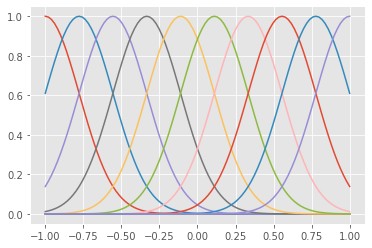

In [3]:
M = 10
def phi_gauss(x):
  gamma = 10
  return np.exp( - (x - np.linspace(-1,1,M))**2 * gamma)

X = np.linspace(-1,1,100)
Y = np.array([phi_gauss(x) for x in X]) #(100, M)
for i in range(M):
  plt.plot(X, Y.T[i])

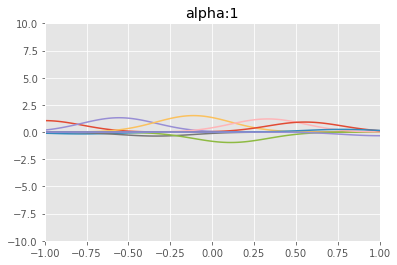

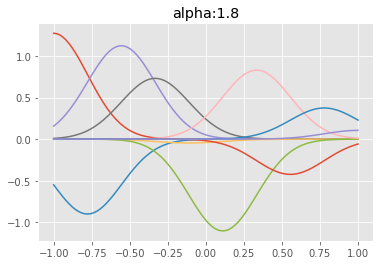

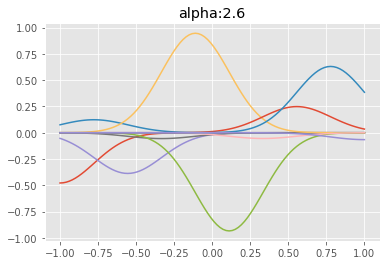

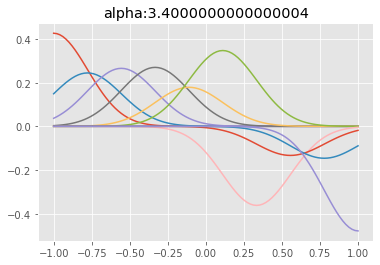

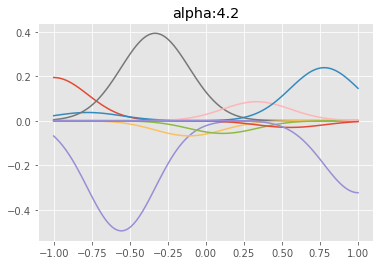

In [4]:

plt.xlim(-1,1)
plt.ylim(-10,10)

x = np.linspace(-1,1, 100)
alpha=1
for i in range(5):
  w = np.random.normal(np.zeros(M), np.eye(M)/alpha)
  y = [w@np.vectorize(phi_gauss)(x_) for x_ in x] #(100)
  plt.plot(x,y)
  plt.title(f"alpha:{alpha}")
  plt.show()
  alpha += 0.8

### ガウスカーネルを直接定義する

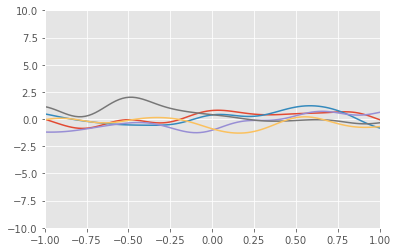

In [5]:
N = 100
alpha = 1
gamma = 10
def k(x_, x):
  return np.exp(-(x_ - x) ** 2 * gamma)

x = np.linspace(-1,1,N)
K = np.zeros((N,N))
for i in range(N):
  K[i, :] = np.array( [k(x_, x[i]) for x_ in x] )

plt.xlim(-1,1)
plt.ylim(-10,10)

for i in range(5): # yをサンプリング
  y = np.random.multivariate_normal(np.zeros(N), K/alpha)
  plt.plot(x,y)
plt.show()

### kernel function -Ornstein-Uhlenbeck process-

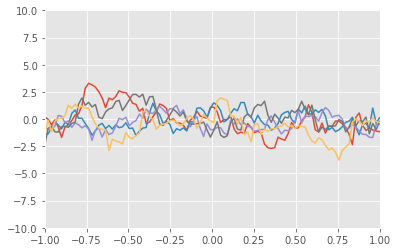

In [6]:
N = 100
alpha = 1
gamma = 10
def k(x_, x):
  return np.exp(-abs(x - x_) * gamma)

x = np.linspace(-1,1, N) 
K = np.zeros([N,N])
for i in range(N):
  K[i, :] = np.array( [k(x_, x[i]) for x_ in x] )

plt.xlim(-1,1)
plt.ylim(-10,10)

for i in range(5):
  y = np.random.multivariate_normal(np.zeros(N), K/alpha)
  plt.plot(x,y)
plt.show()

### gaussian process regression


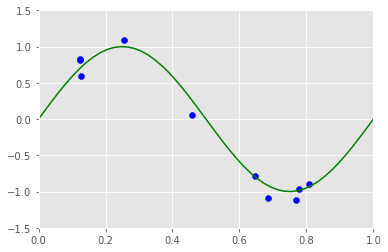

In [10]:
n = 10

train_X = np.random.uniform(0,1,n)
train_t = np.sin(2 * np.pi * train_X) + np.random.normal(0, 0.1, n)
plt.scatter(train_X, train_t, c="b")
plt.plot(np.linspace(0,1), np.sin(2*np.pi*np.linspace(0,1)), c="g")
plt.xlim(0,1)
plt.ylim(-1.5,1.5)
plt.show()

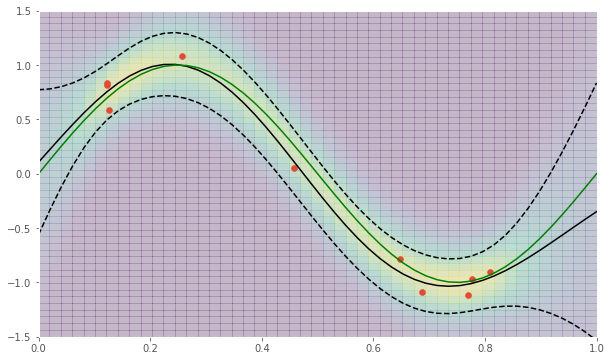

In [30]:
beta = 20
N = 10
theta0 = 10
theta1 = 10
theta2 = 10
theta3 = 10
def k(x_, x):
  return theta0 * np.exp(-theta1*(np.abs(x_ - x)**2)/2) + theta2 + theta3* x_ * x

K = np.zeros([n,n])
for i in range(n):
  K[i, :] = np.array( [k(x_, train_X[i]) for x_ in train_X] )

a = LA.solve(K + np.eye(n) / beta, train_t) 

def m(x):
  return k(train_X, x)@a

C_inv = LA.inv(K + np.eye(n) / beta)

def sigma(x):
  return np.sqrt(k(x,x)+(1/beta) - k(train_X, x) @ C_inv @ k(train_X, x))

def norm(x,t):
  return stats.norm(m(x), sigma(x)).pdf(t)

def graph(f):
  x_, y_ = np.meshgrid(np.linspace(0,1), np.linspace(-1.5, 1.5))
  Z = np.vectorize(f)(x_, y_)

  plt.figure(figsize=(10,6))
  plt.pcolor(x_,y_,Z,alpha=0.2)
  plt.scatter(train_X, train_t)

  # 予測分布の平均と1シグマパイプ
  x = np.linspace(0,1)
  y = np.vectorize(m)(x)
  plt.plot(x,y, c="k")
  plt.plot(x,y+np.vectorize(sigma)(x), "k--")
  plt.plot(x,y-np.vectorize(sigma)(x), "k--")
  
  plt.xlim(0,1)
  plt.ylim(-1.5, 1.5)
  plt.plot(np.linspace(0,1), np.sin(2 * np.pi * np.linspace(0,1)), c ="g")
  plt.show()

graph(norm)

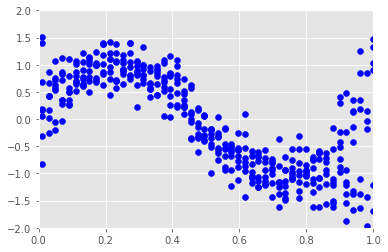

In [34]:
plt.xlim(0,1)
plt.ylim(-2.0, 2.0)

x = np.linspace(-1,1,100)
for i in range(8):
  y = [np.random.normal(m(x_), sigma(x_)) for x_ in x]
  plt.scatter(x, y, c="b")
plt.show()

### 識別

a(x)に対する事前分布を観察

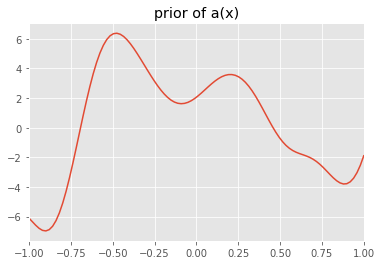

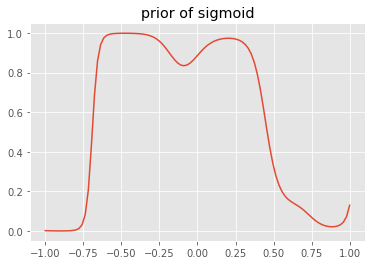

In [37]:
N = 100
alpha = 0.05
gamma = 10
def k(x_, x):
  return np.exp(-(x - x_)**2 * gamma)

X = np.linspace(-1,1,N)
K = np.zeros([N,N])
for i in range(N):
  K[i,:] = np.array([k(X[i], x_) for x_ in X])

plt.xlim(-1,1)

y = np.random.multivariate_normal(np.zeros(N), K/alpha)
y_sig = sigmoid(y)
plt.plot(x,y)
plt.title("prior of a(x)")
plt.show()
plt.title("prior of sigmoid")
plt.plot(x,y_sig)
plt.show()

In [39]:
gamma = 10
nu = 0.1

N = 100
train_x = np.zeros((N,2)) #(N,2)
train_x[:,0] = np.random.uniform(-1,1,N)
train_x[:,1] = np.random.uniform(-1,1,N)

train_t = train_x[:,0]**2 + train_x[:,1]**2 - 0.4 > 0

def W(a):
  return np.diag(sigmoid(a)*(1-sigmoid(a)))

def kernel(x_, x):
  return np.exp(-sum((x_ - x)**2) * gamma) #二次元よりsumが必須

K = np.zeros((N,N))
for i in range(N):
  K[i, :] = np.array([ kernel(train_x[i], x) for x in train_x])

C = K + nu*np.eye(N)

# alpha を求める

a = np.random.normal(0,1,N)

MAX_ITER = 100
for i in range(MAX_ITER):
  a_ = C@LA.solve(np.eye(N) + W(a)@C, train_t - sigmoid(a) + W(a)@a)
  if LA.norm((a_ - a)/a) < 1e-10:
    break
  a = a_
print(LA.norm(a_-a)/a,i)

[ 2.65119382e-12 -1.90709062e-12 -3.91470844e-12  2.30934677e-12
 -3.27522690e-12 -1.74230035e-11  2.06320431e-12  2.41030395e-12
 -1.74461740e-12  2.29301018e-12 -1.83905345e-12  1.95160641e-12
  3.31081552e-12 -4.04742157e-12  3.25195254e-12 -1.95356401e-12
  3.09283946e-12  1.41206779e-11 -1.86920098e-12  4.06761856e-12
  1.74830708e-12  1.70886612e-12  2.23333688e-12  2.23840494e-12
  1.97150522e-12  1.60723651e-12  3.37430565e-12  2.09460804e-12
  2.88225481e-12  7.15605227e-12 -1.78722905e-12 -2.13545790e-12
 -8.64512863e-12  1.68913238e-12  2.18720386e-12 -2.98991566e-12
  2.20367686e-12  2.24001383e-12  1.99648272e-12  9.81328948e-12
  2.97085877e-12  2.99638571e-12 -5.15057396e-12  3.74605539e-12
  2.33260567e-12  1.90692218e-12  2.27653122e-12 -1.63672429e-12
  2.67668937e-11 -4.65456720e-12  2.76495918e-12  2.11464914e-12
  3.56786869e-12  2.03781178e-12  2.00946540e-12 -1.92301586e-12
  2.55862545e-12 -7.92471275e-12  1.90064942e-12 -4.97052782e-12
  2.88205991e-12  2.40442

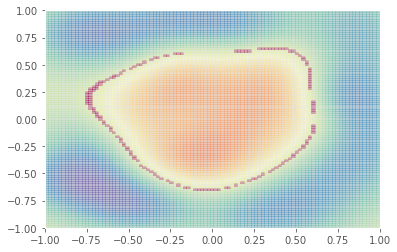

In [48]:
def kernel(x_, x):
    return np.exp(-sum((x_- x)**2) * gamma)
def compute_z(a, x):
  k = np.zeros(N)
  for i in range(N):
        k[i] = kernel(train_x[i], x)
  mu = k.T@(train_t - sigmoid(a))
  sigma2 = kernel(x,x) + nu - k.dot(LA.inv(LA.inv(W(a)) + C)).dot(k)
  return sigmoid(mu/np.sqrt(1+np.pi*sigma2/8)) 

X,Y = np.meshgrid(np.linspace(-1,1,100), np.linspace(-1,1,100))
Z = np.vectorize(lambda x,y: compute_z(a,np.array([x,y])))(X,Y)

plt.xlim(-1,1)
plt.ylim(-1,1)
Z_ = Z.copy()
Z_[(Z<0.51) & (Z>0.49)] = 0
plt.pcolor(X,Y,Z_,alpha=0.3,cmap=cm.Spectral)
plt.show()

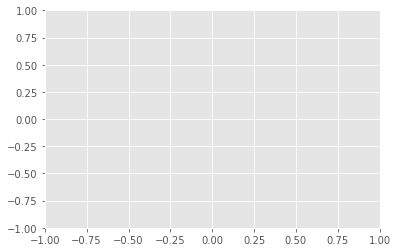

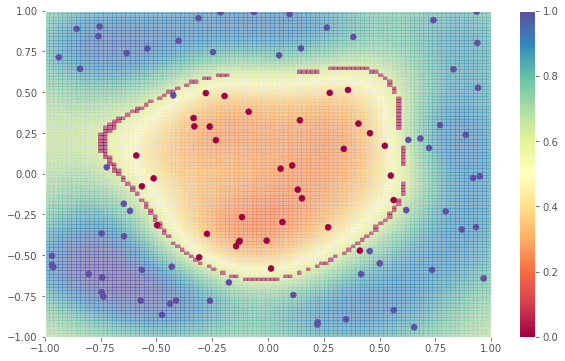

In [53]:
plt.xlim(-1,1)
plt.ylim(-1,1)
Z_ = Z.copy()
Z_[(Z<0.51) & (Z>0.49)] = 0
plt.figure(figsize=(10,6))
plt.pcolor(X,Y,Z_,alpha=0.5,cmap=cm.Spectral)
plt.scatter(train_x[:,0],train_x[:,1], c=train_t,cmap=cm.Spectral)
plt.colorbar()
plt.show()